In [37]:
import glob
from astropy.table import Table
import fitsio
import os
import matplotlib.pyplot as plt
from datetime import datetime
import pytz
import numpy as np
from scipy import stats
import pandas as pd

In [46]:
def process_fits_file(fafn):
    tile_data = {}
    _, h = fitsio.read(fafn, "PRIMARY", header=True)
    
    try:
        program = h["FAPRGRM"]
    except KeyError:
        print('failed FAPRGM with', fafn)
        return None
        
    try:
        date_string = h["NOWTIME"]
    except KeyError:
        print('failed NOW TIME with', fafn)
        return None
    
    tile_data["program"] = h["FAPRGRM"]
    tile_data["ra"] = h["TILERA"]
    tile_data["dec"] = h["TILEDEC"]
    
    datetime_obj = datetime.strptime(date_string, '%Y-%m-%dT%H:%M:%S%z').replace(tzinfo=pytz.UTC)
    print(datetime_obj)
    reference_date = datetime(2021, 5, 14, tzinfo=pytz.UTC) # The start of the main survey
    days_difference = (datetime_obj - reference_date).total_seconds()/(24.0*3600.0)
    tile_data["days_difference"] = days_difference
    
    d = Table(fitsio.read(fafn, "FIBERASSIGN"))

    sky = d["OBJTYPE"] == "SKY"
    good_fibers = d["FIBERSTATUS"]==0 
    expid_str = fafn.split(os.path.sep)[-2]
    
    tile_data["nsky"] = np.count_nonzero(sky)
    tile_data["nskygoodfiber"] = np.count_nonzero(sky&good_fibers)
    tile_data["nskybadfiber"] = np.count_nonzero(sky&(~good_fibers))
    tile_data["expid"] = int(expid_str)
    tile_data["nlowp"] = np.count_nonzero(d["PRIORITY"]<1400)
    tile_data["nverylowp"] = np.count_nonzero(d["PRIORITY"]<100)
    
    return tile_data

def process_fits_files(fafns):
    tile_nsky = []
    tile_nsky_goodfiber = []
    tile_nsky_badfiber = []
    tile_nlowp = []
    tile_nverylowp = []
    expid = []
    tile_program = []
    tile_ra = []
    tile_dec = []
    tile_days = []
    

    for fafn in fafns:
        tile_data = process_fits_file(fafn)
        if tile_data:
            tile_program.append(tile_data["program"])
            tile_ra.append(tile_data["ra"])
            tile_dec.append(tile_data["dec"])
            tile_days.append(tile_data["days_difference"])
            tile_nsky.append(tile_data["nsky"])
            tile_nsky_goodfiber.append(tile_data["nskygoodfiber"])
            tile_nsky_badfiber.append(tile_data["nskybadfiber"])
            tile_nlowp.append(tile_data["nlowp"])
            tile_nverylowp.append(tile_data["nverylowp"])
            expid.append(tile_data["expid"])
            
    data = {"tile_nsky": np.array(tile_nsky),
            "tile_nsky_goodfiber":np.array(tile_nsky_goodfiber),
            "tile_nsky_badfiber":np.array(tile_nsky_badfiber),
            "tile_nlowp":np.array(tile_nlowp),
            "tile_nverylowp":np.array(tile_nverylowp),
            "expid": np.array(expid),
            "tile_program": np.array(tile_program),
            "tile_ra": np.array(tile_ra),
            "tile_dec": np.array(tile_dec),
            "tile_days": np.array(tile_days)
    }
    df = pd.DataFrame(data)
    return df

def process_year(year):
    fafns = sorted(glob.glob("/global/cfs/cdirs/desi/spectro/data/{}*/????????/fiberassign*fits.gz".format(year)))
    print('gathered {} files'.format(len(fafns)))
    df_year = process_fits_files(fafns)
    filename = '{}_nsky_lowp_data.csv'.format(year)
    df_year.to_csv(filename, index=False)

In [47]:
for year in [2021, 2022, 2023, 2024]:
    process_year(year)

gathered 7292 files
failed FAPRGM with /global/cfs/cdirs/desi/spectro/data/20210106/00071093/fiberassign-080641.fits.gz
failed FAPRGM with /global/cfs/cdirs/desi/spectro/data/20210106/00071094/fiberassign-080641.fits.gz
failed FAPRGM with /global/cfs/cdirs/desi/spectro/data/20210106/00071095/fiberassign-080641.fits.gz
failed FAPRGM with /global/cfs/cdirs/desi/spectro/data/20210106/00071096/fiberassign-080641.fits.gz
failed FAPRGM with /global/cfs/cdirs/desi/spectro/data/20210106/00071097/fiberassign-080641.fits.gz
failed FAPRGM with /global/cfs/cdirs/desi/spectro/data/20210106/00071099/fiberassign-080641.fits.gz
failed FAPRGM with /global/cfs/cdirs/desi/spectro/data/20210106/00071100/fiberassign-080641.fits.gz
failed FAPRGM with /global/cfs/cdirs/desi/spectro/data/20210106/00071101/fiberassign-080642.fits.gz
failed FAPRGM with /global/cfs/cdirs/desi/spectro/data/20210106/00071102/fiberassign-080642.fits.gz
failed FAPRGM with /global/cfs/cdirs/desi/spectro/data/20210106/00071103/fiberas

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [48]:
data_A = pd.read_csv('2021_nsky_lowp_data.csv')
data_B = pd.read_csv('2022_nsky_lowp_data.csv')
data_C = pd.read_csv('2023_nsky_lowp_data.csv')
data_D = pd.read_csv('2024_nsky_lowp_data.csv')


In [49]:
data = pd.concat([data_A, data_B, data_C, data_D], axis=0, ignore_index=True)

0.08187439729428847
0.15580772901274217


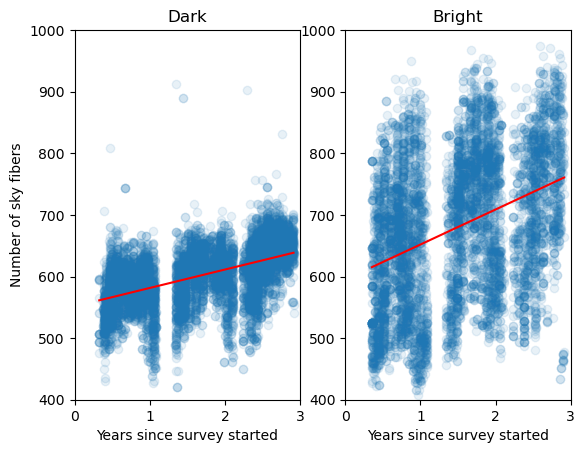

In [59]:
plt.subplot(1,2,1)

plt.title('Dark')
ii = (data['tile_program']=='dark') #& (data['day']>600)
plt.scatter(data['tile_days'][ii]/365.0, data['tile_nsky'][ii], alpha=0.1)

plt.ylabel("Number of sky fibers")
plt.xlabel("Years since survey started")
plt.ylim(400,1000)
plt.xlim(0., 3)


slope, intercept, r_value, p_value, std_err = stats.linregress(data['tile_days'][ii], data['tile_nsky'][ii])
x = np.sort(data['tile_days'][ii])
plt.plot(x/365., slope*x + intercept, color='red')
print(slope)

plt.subplot(1,2,2)
plt.title('Bright')
ii = (data['tile_program']=='bright') #& (data['day']>600)
plt.scatter(data['tile_days'][ii]/365.0, data['tile_nsky'][ii], alpha=0.1)

plt.xlabel("Years since survey started")
plt.ylim(400,1000)
plt.xlim(0., 3.)

slope, intercept, r_value, p_value, std_err = stats.linregress(data['tile_days'][ii], data['tile_nsky'][ii])
x = np.sort(data['tile_days'][ii])
plt.plot(x/365., slope*x + intercept, color='red')
print(slope)
plt.savefig('sky_fibers_vs_time.pdf')
plt.savefig('sky_fibers_vs_time.png')

0.45973401052755786
0.6662492831068763


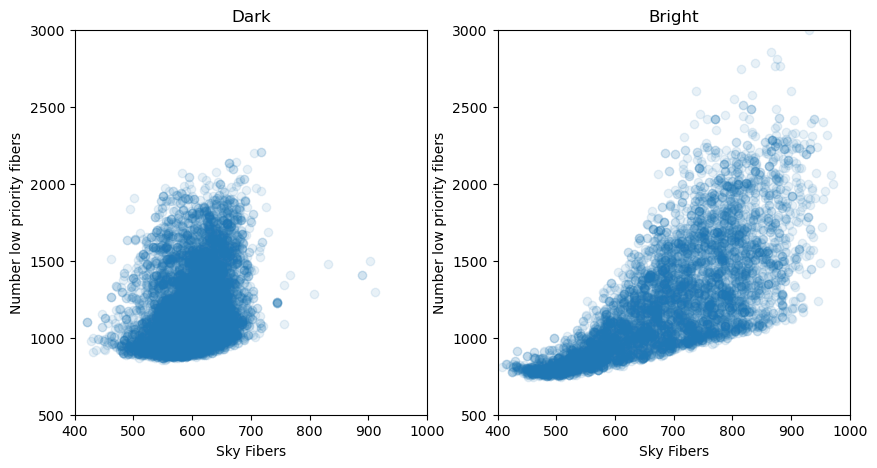

In [99]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

plt.title('Dark')
ii = (data['tile_program']=='dark') #& (data['day']>600)
plt.scatter(data['tile_nsky'][ii], data['tile_nverylowp'][ii], alpha=0.1)

plt.ylabel("Number low priority fibers")
plt.xlabel("Sky Fibers")
plt.ylim(500,3000)
plt.xlim(400,1000)


slope, intercept, r_value, p_value, std_err = stats.linregress(data['tile_days'][ii], data['tile_nverylowp'][ii])
x = np.sort(data['tile_days'][ii])
plt.plot(x/365., slope*x + intercept, color='red')
print(slope)

plt.subplot(1,2,2)
plt.title('Bright')
ii = (data['tile_program']=='bright') #& (data['day']>600)
plt.scatter(data['tile_nsky'][ii], data['tile_nverylowp'][ii], alpha=0.1)

plt.ylabel("Number low priority fibers")
plt.xlabel("Sky Fibers")
plt.ylim(500,3000)
plt.xlim(400,1000)

slope, intercept, r_value, p_value, std_err = stats.linregress(data['tile_days'][ii], data['tile_nverylowp'][ii])
x = np.sort(data['tile_days'][ii])
plt.plot(x/365., slope*x + intercept, color='red')
print(slope)

0.45973401052755786
0.6662492831068763


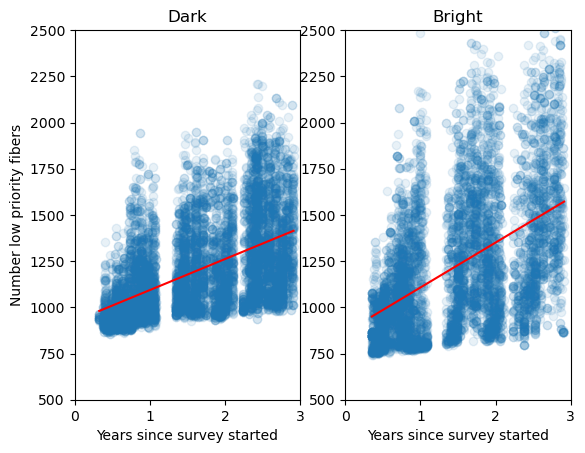

In [98]:
plt.subplot(1,2,1)

plt.title('Dark')
ii = (data['tile_program']=='dark') #& (data['day']>600)
plt.scatter(data['tile_days'][ii]/365.0, data['tile_nverylowp'][ii], alpha=0.1)

plt.ylabel("Number low priority fibers")
plt.xlabel("Years since survey started")
plt.ylim(500,2500)
plt.xlim(0., 3)


slope, intercept, r_value, p_value, std_err = stats.linregress(data['tile_days'][ii], data['tile_nverylowp'][ii])
x = np.sort(data['tile_days'][ii])
plt.plot(x/365., slope*x + intercept, color='red')
print(slope)

plt.subplot(1,2,2)
plt.title('Bright')
ii = (data['tile_program']=='bright') #& (data['day']>600)
plt.scatter(data['tile_days'][ii]/365.0, data['tile_nverylowp'][ii], alpha=0.1)

plt.xlabel("Years since survey started")
plt.ylim(500,2500)
plt.xlim(0., 3.)

slope, intercept, r_value, p_value, std_err = stats.linregress(data['tile_days'][ii], data['tile_nverylowp'][ii])
x = np.sort(data['tile_days'][ii])
plt.plot(x/365., slope*x + intercept, color='red')
print(slope)

0.45973401052755786


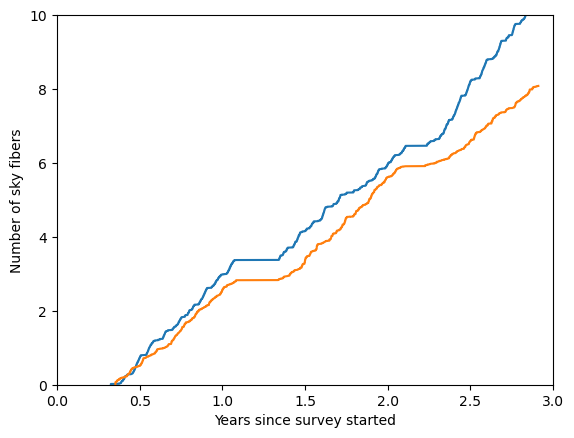

In [86]:

ii = (data['tile_program']=='dark') #& (data['day']>600)
dark_time = np.array(data['tile_days'][ii]/365.0)
dark_counts = np.array(data['tile_nverylowp'][ii])
ll = np.argsort(dark_time)
dark_time = dark_time[ll]
dark_counts = dark_counts[ll]
plt.plot(dark_time, np.cumsum(dark_counts)/1E6)

plt.ylabel("Number of sky fibers")
plt.xlabel("Years since survey started")


jj = (data['tile_program']=='bright') #& (data['day']>600)
bright_time = np.array(data['tile_days'][jj]/365.0)
bright_counts = np.array(data['tile_nverylowp'][jj])
mm = np.argsort(bright_time)
bright_time = bright_time[mm]
bright_counts = bright_counts[mm]

plt.plot(bright_time, np.cumsum(bright_counts)/1E6)

plt.xlabel("Years since survey started")
plt.ylim(0,10)
plt.xlim(0., 3.)

slope, intercept, r_value, p_value, std_err = stats.linregress(data['tile_days'][ii], data['tile_nverylowp'][ii])
x = np.sort(data['tile_days'][ii])
plt.plot(x/365., slope*x + intercept, color='red')
print(slope)